# Capstone Project: The Battle of Neighborhoods (week 2)

# An analysis of neighborhoods in Munich using data science methodologies


# Table of Content

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# 1. Introduction <a name="introduction"></a>
In this section a description of the problem and a discussion of the background is provided.

## 1. 1 Background Information

Almost everybody is moving to another place - at least once in a lifetime. Starting to study in a new city, during a semester abroad, after changing the job, or moving together with a new partner are only some of the reasons why people would find a new place to live. Besides the price of the housing, another important factor is its surrounding. When moving to another place, people most likely would like to find a place that is comparable to the current home to feel comfortable. Even though different people put emphasis on different venues: For example, for some it might be interesting to have a park nearby, while other prefer good restaurants or grocery stores nearby - they all have the same problem in common: How to find a place that meets the personal requirements? In this report we will answer this question using Data Science Methods. 

## 1. 2 Problem statement: Where should John move within Munich

In this report, we are trying to find a borough in Munich for John, where he most likely would feel comfortable. John is 27 years old and is currently living in _Schwanthalerhöhe, 80335_. He really enjoys living there. Unfortunately, his landlord needs the apartment for himself - that is why John needs to move to another place.  He would like to use this as a chance to explore new neighborhoods in Munich. _Schwanthalerhöhe_ is directly located at the _Theresienwiese_ , a park where John starts his day with running and grabbing a coffee afterwards. That is why it would be nice to have a park and coffee store close to the new home. John works for a big consulting company, that is why he comes home pretty late. It would therefore be good to have a grocery store nearby. When it is getting too late at work, he likes to grab dinner in a restaurant. That is why it would be a plus to have bars or restaurants close to his home. The price per m² from his current appartment is: 34.29€/m². Finding one with lower price/m² would be perfect. Summarized, John would most likely enjoy to have the following venues nearby:
* park nearby
* coffee store
* restaurants & bars
* grocery store
* If possible, cheaper price per m² than the current apartment (34.29€/m²) 

All in all, John really loves his current borough, that is why we need to find out in addition, which of the other boroughs is most similar to the one he is currently living in. We will use data science methods to identify the most promising neighborhoods based on these criteria. 

## 1. 3 Target audience for this report
This report is an analysis of the boroughs in Munich customized to the needs of John (park, coffee store... nearby). However, the approach is applicable to all people with any specific needs. The information gathered from Foursquare in combination with data science methods are a good basis to derive data driven decisions regarding boroughs that best fit the specific needs at hand. It would even be possible for real estate agents to use some similar approaches to find the perfect home for their customers.

# 2. Data  <a name="data"></a>
In this section a description of the data and how it will be used to solve the problem is provided. 

## 2.1 Description of the Data
In order to find the most promising borough for John the following data is needed: 

1. __Average price per m² of the apartments in Munich:__ This information is gathered through web scraping from this webpage 'https://de.statista.com/statistik/daten/studie/260438/umfrage/mietpreise-in-muenchen-nach-bezirken/'. Some modifications need to be performed to transform the dataframe in a format that can be used for further analysis. Detailed steps can be found in the _Data preparation_ section.

2. __Information about the venues in all boroughs of Munich (including those around Johns home):__ This information is gathered through web scraping from this webpage 'https://www.muenchen.de/leben/service/postleitzahlen.html'. As the format does not fit our further data processing requirements, it needs to be transformed. Once the data is in the right format, the Geocoder Python package (https://geocoder.readthedocs.io/index.html) is used to receive the latitude and logitude coordinate for all of the boroughs. The boroughs and their corresponding latitude and longitude are used as input for FourSquare to source information about the boroughs. 

## 2.2 How will the data be used to solve the problem

We will start with an __exploratory data analysis__, where we intend to understand the underlying data. The describe method provides valuable insights for the "average price per m² of the apartments in Munich" investigations. 

To get a first impression about the distribution of venues in Munich, they are visualized using Folium map. The chosen color code will give immediate yet superficial insight, how John's favourite venues are distributed across Munich and how the surrounding of his actual location looks like. 

For the further analysis, the venues will be divided into two types: Firstly, we have a data frame containing all venues of John's personal interest (i.e. parks, coffee stores, restaurants, bars and grocery stores) and one containing all other venues. This subdivision will let us analyse which boroughs are most similar to John's current neighborhood in terms of his personal preferences but also tells us the most common venues within the boroughs. This ensures to find the top borough in terms of John's interests - which is of course the most important criterion - but also provides a list for John with the most common venues in the neighborhoods that he could use for his final decision.

__One hot encoding__ and __k-means__ will narrow the list of the most promising boroughs to three. Combining these three with the pricing analysis lets us recommend the best borough match for John. 



## 2.3 Python Libraries
For this report the following libraries are used: 


In [133]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import itertools

#Libraries for plots
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import geocoder

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#Library for k-mean algoritm
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 2.4 Data preparation
### a) Get boroughs of munich and corresponding postal code in Dataframe: 
First of all,the __boroughs of munich and the corresponding postal codes__ are scraped from the webpage: https://www.muenchen.de/leben/service/postleitzahlen.html and transformed the data into a pandas dataframe as shown below:

In [61]:
url = 'https://www.muenchen.de/leben/service/postleitzahlen.html'
df_munichPoctcode = pd.read_html(url, header=0)[0]
df_munichPoctcode.head()

,Stadtteil,Postleitzahl
0,Allach-Untermenzing,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,"80331, 80333, 80335, 80336, 80469, 80538, 80539"
2,Au-Haidhausen,"81541, 81543, 81667, 81669, 81671, 81675, 81677"
3,Aubing-Lochhausen-Langwied,"81243, 81245, 81249"
4,Berg am Laim,"81671, 81673, 81735, 81825"


In order to work better with the data, the following steps are performed on the dataframe:
1. Rename columns: The column names will be translated to english
2. Restructure Data, that we have one single row for every postal code

In [62]:
#Step 1: Rename columns
df_munichPoctcode.rename(columns={'Stadtteil':'Borough', 'Postleitzahl':'PostalCode'}, inplace = True)
df_munichPoctcode.head()

,Borough,PostalCode
0,Allach-Untermenzing,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,"80331, 80333, 80335, 80336, 80469, 80538, 80539"
2,Au-Haidhausen,"81541, 81543, 81667, 81669, 81671, 81675, 81677"
3,Aubing-Lochhausen-Langwied,"81243, 81245, 81249"
4,Berg am Laim,"81671, 81673, 81735, 81825"


If you look at the column PostalCode, you'll notice, that there are many postal codes in the _PostalCode_ column separated by a comma, each refering to a different area of the _borough_. As we would like to compare all of them, we need to get all of these postal codes in a separate row.  

In [63]:
#Step 2: Restructure Data

##Save all boroughs in a list
borough_list = df_munichPoctcode['Borough'].to_list()
borough_list = list(itertools.chain.from_iterable(itertools.repeat(x, 9) for x in borough_list))

#Save all Postalcodes in a list
df_postal = df_munichPoctcode[['PostalCode']].PostalCode.str.split(",",expand=True)
postalcode_list = []

count = 0
#Copy all postal codes in one column under each other
for element in (range(0,len(df_postal))):
    postalcode_list.extend(df_postal.iloc[count])
    count+=1
postalcode_list

#Combine borough and postal code list in new dataframe 
df_mucPostcode = pd.DataFrame(list(zip(borough_list, postalcode_list)), columns =['Borough', 'PostalCode']) 
df_mucPostcode.head(20)

#Drop columns that contain nans
df_mucPostcode.dropna(inplace = True)
df_mucPostcode.reset_index(drop=True, inplace=True)
df_mucPostcode.head()

,Borough,PostalCode
0,Allach-Untermenzing,80995
1,Allach-Untermenzing,80997
2,Allach-Untermenzing,80999
3,Allach-Untermenzing,81247
4,Allach-Untermenzing,81249


### b) Get average price per square meter of appartments in the boroughs of munich in Dataframe: 
In order to get the __price per square meter of appartments in the boroughs of munich__ the webpage: https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html is scraped and the data is stored in a pandas dataframe as shown below:

In [64]:
url = 'https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html'
df_mucPrice = pd.read_html(url, header=0)[0]
df_mucPrice.head(30)
df_mucPrice.dropna(inplace = True)

df_mucPrice.head()

,PLZ,Miete,Trend,Kaufpreis,Trend.1
1,80995,1410.0,"1,1%",5000,"6,8%"
2,80997,1325.0,"-1,9%",5430,"12,4%"
3,80999,1305.0,"5,2%",5880,"11,4%"
4,81247,1455.0,"2,5%",6520,"1,4%"
5,81249,1325.0,"5,6%",5100,"3,4%"


In order to work better with the data, the following steps are performed on the dataframe:
1. Drop columns that are not needed for further analysis
2. Rename columns: The column names will be translated to english
3. Restructure Data: we would like to have the price per square mether in €instead of Cents.

In [65]:
#Step 1: Drop columns
df_mucPrice.drop(["Trend", "Trend.1", "Kaufpreis"],  axis = 1, inplace = True)

In [66]:
#Step 2: Rename columns
df_mucPrice.rename(columns={'PLZ':'PostalCode', 'Miete':'PricePerm2'}, inplace = True)

In [67]:
#Step 3: Restructure Data
df_mucPrice["PricePerm2"] = df_mucPrice["PricePerm2"] /100
df_mucPrice.head()

,PostalCode,PricePerm2
1,80995,14.10
2,80997,13.25
3,80999,13.05
4,81247,14.55
5,81249,13.25


### c) Merge Dataframes from a) and b) to have one single dataframe 

To merge the dataframes, the Postal codes are set as index in both dataframes and converted to type int:

In [68]:
df_mucPostcode["PostalCode"] = df_mucPostcode["PostalCode"].astype(int) 
df_mucPrice["PostalCode"] = df_mucPrice["PostalCode"].astype(int) 
df_mucPrice.set_index(['PostalCode'], inplace = True)
df_mucPostcode.set_index(['PostalCode'],inplace = True)

In [69]:
print("There are {} different postal codes in munich. However, we only have prices for {} postal codes".format(df_mucPostcode.shape[0], df_mucPrice.shape[0]))

There are 127 different postal codes in munich. However, we only have prices for 69 postal codes


As there is no price for every postal code in the 'df_mucPostcode' dataframe, a common method is used: for those areas where we have missing prices for the postal codes, the average of the borough is used. For example:

Nr | PostalCode | boough              | Price per m²
---|------------|---------------------|--------
1  | 81369      |	Sendling-Westpark | __NaN__
2  | 81373	    |   Sendling-Westpark | __NaN__
3  | 81377      |	Sendling-Westpark | 14.75
4  | 81379      |	Sendling-Westpark | __NaN__
5  | 80686      |	Sendling-Westpark | 16.40

will become 15.575

Nr | PostalCode | boough              | Price per m²
---|------------|---------------------|--------
1  | 81369      |	Sendling-Westpark | __15.575__
2  | 81373	    |   Sendling-Westpark | __15.575__
3  | 81377      |	Sendling-Westpark | 14.75
4  | 81379      |	Sendling-Westpark | __15.575__
5  | 80686      |	Sendling-Westpark | 16.40

where __15.575__ is calculated as the average Price per m² of the specific boroughs: (14.75+16.40)/2
This calculation is done for every single borough.

In [70]:
#Join Dataframes
df_munich = df_mucPostcode.join(df_mucPrice)
df_munich.reset_index(inplace = True)


#Group values based on their borough and calculate mean price
df_munich_grouped = df_munich.groupby('Borough').mean()
df_munich_grouped

##If there is a NaN, replace the NaN with the mean price for this region, calculated in the previous step
pricelist = []

for index in range(0,len(df_munich["PricePerm2"])):
    
    if (np.isnan( df_munich.loc[index,"PricePerm2"] )== True):
        pricelist.append(df_munich_grouped.loc[df_munich.loc[index,"Borough"],"PricePerm2"])
    else:
        pricelist.append(df_munich.loc[index,"PricePerm2"])
    
df_price = pd.DataFrame(pricelist, columns=['New Price'])   
df_muc = df_munich.join(df_price)
df_muc.head()

,PostalCode,Borough,PricePerm2,New Price
0,80331,Altstadt-Lehel,22.3,22.3
1,80333,Altstadt-Lehel,19.1,19.1
2,80333,Altstadt-Lehel,19.1,19.1
3,80333,Maxvorstadt,19.1,19.1
4,80333,Maxvorstadt,19.1,19.1


In [71]:
#Drop column PricePerm2 and make column "new Price" as new priceperm2
df_muc.drop(["PricePerm2"],  axis = 1, inplace = True)
df_muc.rename(columns={'New Price':'PricePerm2'}, inplace = True)
df_muc.head()

,PostalCode,Borough,PricePerm2
0,80331,Altstadt-Lehel,22.3
1,80333,Altstadt-Lehel,19.1
2,80333,Altstadt-Lehel,19.1
3,80333,Maxvorstadt,19.1
4,80333,Maxvorstadt,19.1


In [72]:
#Check if there are NANs in the data
df_muc.isnull().sum(axis = 0)

PostalCode    0
Borough       0
PricePerm2    5
dtype: int64

As can be seen, there are still 5 rows with NANs in the dataframe. The following rows still contain NANs:

In [73]:
df_muc[df_muc['PricePerm2'].isnull()]

,PostalCode,Borough,PricePerm2
123,81379,Thalkirchen-Obersendling-Fürstenried-Forstenri...,NaN
124,81475,Thalkirchen-Obersendling-Fürstenried-Forstenri...,NaN
125,81476,Thalkirchen-Obersendling-Fürstenried-Forstenri...,NaN
126,81477,Thalkirchen-Obersendling-Fürstenried-Forstenri...,NaN
127,81479,Thalkirchen-Obersendling-Fürstenried-Forstenri...,NaN


As you can see all of the remaining NaN values are in the borough Thalkirchen-Obersendling-Fürstenried-Forstenried-Solln, where we do not have any reference value. That is why these rows are dropped. Thalkirchen-Obersendling-Fürstenried-Forstenried-Solln is not used in the further investigation.

In [74]:
#Drop lines with NANs
df_muc.dropna(subset=['PricePerm2'], inplace = True)

#Check again that there are no NANs in the data
df_muc.isnull().sum(axis = 0)

#reset index
df_muc.reset_index(drop=True, inplace=True)

### d) Get Latitude and longitude of each borough
The Geocoder Python package (https://geocoder.readthedocs.io/index.html) is used to get the coordinates (latitude and longitude) for all of the neighborhoods of munich. Therefore a function is defined, that takes as input parameters postalcode and borough and gives back the latitude and longitude of the specific postal code and borough:

In [75]:
##Define function that returns latitude and longitude 
def get_cordinates(postalcode, borogh):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(postalcode, borogh))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude


#Loop through dataframe, that calls for every row the "get_coordinates" function and adds the latitude and longitude 
##in a new column
for rownr in range(0,len(df_muc)):
    postalcode = df_muc.loc[rownr, 'PostalCode'] 
    borogh = df_muc.loc[rownr, 'Borough'] 
    lat, lon = get_cordinates(postalcode, borogh)
    df_muc.loc[df_muc.index[rownr], 'Latitude'] = lat
    df_muc.loc[df_muc.index[rownr], 'Longitude'] = lon

In [76]:
#check if the latitude and longitude is added in the dataframe
df_muc.head()

,PostalCode,Borough,PricePerm2,Latitude,Longitude
0,80331,Altstadt-Lehel,22.3,48.13487,11.581988
1,80333,Altstadt-Lehel,19.1,48.13641,11.577540
2,80333,Altstadt-Lehel,19.1,48.13641,11.577540
3,80333,Maxvorstadt,19.1,48.14582,11.565170
4,80333,Maxvorstadt,19.1,48.14582,11.565170


Now this dataframe ( _df_muc_ ) can be used for data exploration. It will be used to compare the price pre square meter of the apartments of the different boroughs.

### e) Get the latitude and longitude of Johns current home
As a reference, the latitude and longitude of Johns current residence are received using the 

In [77]:
address = 'Gollierstr 6, 80339'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat_home = location.latitude
lon_home = location.longitude
print('The geograpical coordinate of Johns current home, Gollierstraße 6 are {}, {}.'.format(lat_home, lon_home))

The geograpical coordinate of Johns current home, Gollierstraße 6 are 48.1358166, 11.5466346.


### f) Use FourSquare to explore the area around the boroughs

To be able to use the Foursquare API, the Foresquare Credentials and Version needs to be defines: 

In [78]:
CLIENT_ID = '3K5SQILC2FEL3VKCMALM0G2IHU1NYBAGO2NMF34UDROZX2II' # your Foursquare ID
CLIENT_SECRET = 'RBHGDCD0ZV4EM4V3UBUIGUJOGBODUQ11TPX15KY32DSG0XAP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 750 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3K5SQILC2FEL3VKCMALM0G2IHU1NYBAGO2NMF34UDROZX2II
CLIENT_SECRET:RBHGDCD0ZV4EM4V3UBUIGUJOGBODUQ11TPX15KY32DSG0XAP


A function is defined, that takes as input the borough as well as the latitude and longitude and gives back the venues around the location provided:

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

All of the boroughs of munich are investigated:

In [82]:
muc_venues = getNearbyVenues(names=df_muc['Borough'],
                                   latitudes=df_muc['Latitude'],
                                   longitudes=df_muc['Longitude']
                                   )

In [90]:
muc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt-Lehel,48.13487,11.581988,Globetrotter,48.134611,11.581879,Sporting Goods Shop
1,Altstadt-Lehel,48.13487,11.581988,Little London,48.135562,11.580961,Steakhouse
2,Altstadt-Lehel,48.13487,11.581988,OOH BABY I LIKE IT RAW,48.134023,11.580400,Café
3,Altstadt-Lehel,48.13487,11.581988,Literatur Moths,48.133762,11.582408,Bookstore
4,Altstadt-Lehel,48.13487,11.581988,Item Shop,48.133460,11.581509,Hobby Shop


For the further analysis, we now have the following data(frames):
1. __df_muc:__ Contains the average price per m² of the apartments in Munich. This dataframe is used to compare the average price per square meter of the boroughs in Munich with the actual price per square meter of Johns apartment.


2. __muc_venues:__ Contains all the venues in the boroughs of Munich. This data frame is used to find boroughs that fits most Johns requirements.

In addition to that, we know that Johns home is in _Gollierstr 6, 80339_ with latitude and longitude of 48.1358166 and 11.5466346.

# 3. Methodology <a name="methodology"></a>
This section represents the main component of the report. It starts with an exploratory data analysis before we dig deeper into solving the problem and applying machine learning algorithms. For the analysis, the venues are divided into two different data frames: Those who are Johns interests (i.e. parks, coffee stores, restaurants, bars and grocery stores) and all the other ones. We will perform __one hot encoding__ to narrow the list of the most promising boroughs for both of the venue data frames. Combining the results with a __k-mean cluster analysis__ of all venues in Munich will provide us the most promising neighborhoods for John.


## 3. 1 Exploratory Data Analysis
As mentioned in the previous section, we have the following four different data sets that will be used to solve the question: Which borough is a good one as Johns new home.

1. __df_muc:__ Contains the average price per m² of the apartments in Munich. This dataframe is used to compare the average price per square meter of the boroughs in Munich with the actual price per square meter of Johns apartment.


2. __muc_venues:__ Contains all the venues in the boroughs of munich. This dataframe is used to find borrouoghs that fits most Johns requirements.

In addition to that, we know that Johns home is in _Gollierstr 6, 80339_ with latitude and longitude of 48.1358166 and 11.5466346.

### a) Average price per square meter

Let us start by visualizing the distribution of Price per squaremeter in Munich using a histogram. 

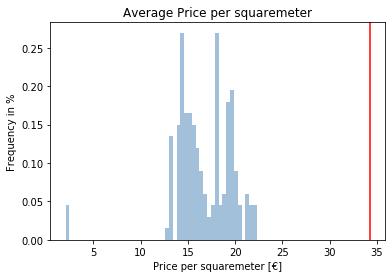

In [92]:
plt.ylabel('Frequency in %')
plt.xlabel('Price per squaremeter [€]')
plt.title('Average Price per squaremeter')

plt.hist(df_muc['PricePerm2'], bins=50, density=True, alpha=0.5, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.axvline(34.29, 0,1, color='red')

This plot gives provides first quantitative insigt into the distribution of prices per squarementer of apartments in Munich. It starts at abbot 13 Euro and goes up to about 24€/m². To understand the exact range of the price per square meter, we use the describe method:

In [94]:
df_muc.describe()["PricePerm2"].to_frame()

,PricePerm2
count,165.000000
mean,16.647293
std,3.147723
min,2.060000
25%,14.650000
50%,16.400000
75%,19.100000
max,22.300000


Johns apartment costs 34.29€/m² and is thus more expensive than all of the averages prices in all boroughs. Thus, no matter where he is going to move, he will most likely find an appartment that has lower price per m² compared to the curent apartment. However, it would be interesting to understand how the price distribution across munich looks like. Therefore a Folium map is used. The price per m² is devided in 6 equal price ranges indicated by its differnt color:

Nr | price per m² range | color      | # of bouroghs
---|--------------------|------------|--------
1  | (2.04, 4.59]       |	purple   | 3
2  | (4.59, 7.12]       |   blue     | 0
3  | (7.12, 9.65]       |	black    | 0
4  | (9.65, 12.18]      |	brown    | 0
5  | (12.18, 14.71]     |	green    | 40
6  |(14.71, 17.24]      |	yellow   | 49
7  |(17.24, 19.77]      |	orange   | 54
8  |(19.77, 22.3]       |	red      | 19

In [95]:
### Create the ranges and colors for different pricing as shown in the table above
df_muc['color'] = pd.cut(df_muc['PricePerm2'], bins=8, 
                              labels=['purple','blue', 'black', 'brown','green','yellow', 'orange', 'red'])
histprice = pd.cut(df_muc['PricePerm2'], bins=8).value_counts().to_frame()
histprice.head()

,PricePerm2
"(17.24, 19.77]",54
"(14.71, 17.24]",49
"(12.18, 14.71]",40
"(19.77, 22.3]",19
"(2.04, 4.59]",3


In [99]:
# create map
mucPrice_map = folium.Map(location=[lat_home, lon_home], zoom_start=11)

#add circles in the colors associated with the defined range
for index, row in df_muc.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         color=row['color'], 
                         fill=True,
                         fill_color=row['color'],
                         fill_opacity=0.8
                       ).add_to(mucPrice_map)

#add an icon at  Johns home
text = 'Johns home'

iframe = folium.IFrame(text, width=700, height=450)
popup = folium.Popup(iframe, max_width=3000)

mucPrice_map.add_child(folium.Marker(location=[lat_home, lon_home], popup=popup,
                     icon=folium.Icon(color='red')))
mucPrice_map

As can be seen from the map, Johns home is within the center of munich, in the most expensive area. As already mentioned, all of the reference prices in our dataframe are lower compared to the one John is currently paying. Consequently, no matter where John is moving, he will most likely find an appartment with lower price per m².

### b) Venues in the borouoghs of munich
In the following the analysis is performed on two different dataframes: 
* using a dataframe that just contains the venues of Johns interest: Parks, coffee, bars, restaurants, grocery stores ( _muc_venueFAV_ ) 
* using a dataframe that contains all other venues ( _muc_venueother_ ) 
Therefore two different dataframes are defined:

In [100]:
#venues of Johns interest
muc_venueFAV = muc_venues[(muc_venues['Venue Category'].str.contains('Park')==True) | (muc_venues['Venue Category'].str.contains('Café')==True) |(muc_venues['Venue Category'].str.contains('Bar')==True) | (muc_venues['Venue Category'].str.contains('Restaurant')==True) | (muc_venues['Venue Category'].str.contains('Grocery')==True)]

#all other venues 
muc_venueother = muc_venues[(muc_venues['Venue Category'].str.contains('Park')==False) & (muc_venues['Venue Category'].str.contains('Café')==False) & (muc_venues['Venue Category'].str.contains('Bar')==False) & (muc_venues['Venue Category'].str.contains('Restaurant')==False) & (muc_venues['Venue Category'].str.contains('Grocery')==False)]

Before we start with a detailed analysis, the distribution of parks, coffee stores, bars, restaurants, grocery stores and other venues within munich is visualized using folium map. The color code is set as follows: 

venue | color      
---|--------------------
parks     |	green   
coffee   |	orange   
bar & restaurants    |	yellow   
grocery    |   blue  
other    |	grey    

In [101]:
#Define dataframes that just contain the specific favourite venues
muc_venuepark = muc_venues[muc_venues['Venue Category'].str.match('Park')]
muc_venuecoffee = muc_venues[muc_venues['Venue Category'].str.match('Café')]
muc_venuebar = muc_venues[(muc_venues['Venue Category'].str.match('Bar')) | (muc_venues['Venue Category'].str.match('Restaurant'))]
muc_venuegrocery = muc_venues[muc_venues['Venue Category'].str.match('Grocery')]

In [106]:
# create map and display it
muc_map = folium.Map(location=[lat_home, lon_home], zoom_start=11)
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(muc_venueother["Venue Latitude"], muc_venueother["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='grey',
        )
    )   

for lat, lng, in zip(muc_venuepark["Venue Latitude"], muc_venuepark["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='green',
        )
    )

for lat, lng, in zip(muc_venuecoffee["Venue Latitude"], muc_venuecoffee["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='orange',
        )
    )    

for lat, lng, in zip(muc_venuebar["Venue Latitude"], muc_venuebar["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='yellow',
        )
    )    

for lat, lng, in zip(muc_venuegrocery["Venue Latitude"], muc_venuegrocery["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='blue',
        )
    )   
    

    
text = 'Johns home'

iframe = folium.IFrame(text, width=700, height=450)
popup = folium.Popup(iframe, max_width=2000)

muc_map.add_child(folium.Marker(location=[48.136320, 11.546980], popup=popup,
                     icon=folium.Icon(color='red')))


#muc_map.save('mymap.html') 

# add incidents to map
muc_map.add_child(incidents)
muc_map

As you can see, currently, John has all of his favourite venues around him. Let us now try to find a comparable borough for John.

## 3. 2 One Hot Encoding

To analyse each neighborhood, one hot encoding is used for both dataframes: 

a) Johns favourite venues: Parks, coffee, bars, restaurants, grocery stores ( _muc_venueFAV_ ) 

b) All venues in munich except of Johns favourite venues ( _muc_venueother_ )

However, while we are defining a "Favourite Score" for dataframe a) ( _muc_venueFAV_ ) , we are focusing on the ten most common venues in the boroughs for dataframe b) ( _muc_venueother_ ). 



### a) Johns favourite venues ( _muc_venuesFAV_ )

As we already know, that John prefers to have parks, coffee stores, bars, restaurants and grocery stores nearby, we use the dataframe _muc_venueFAV_ that just containes these venues. Using one hot encoding, we will identify how many of the favourite venues are located in the different neigborhoods. A "Favorite score" is defined building the normalized sum of favourite venues in the neigborhood. The following steps are performed: 
1. One hot encoding of Johns favourite venues 
2. Smaller modifications 
3. Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood

In [107]:
#Step 1: One hot encoding of Johns favourite venues 
muc_venueFAV_onehot = pd.get_dummies(muc_venueFAV[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe

muc_venueFAV_onehot['Neighborhood'] = muc_venueFAV['Neighborhood'] 
########move neighborhood column to the first column
fixed_columns = [muc_venueFAV_onehot.columns[-1]] + list(muc_venueFAV_onehot.columns[:-1])
muc_venueFAV_onehot = muc_venueFAV_onehot[fixed_columns]

In [108]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
muc_venueFAV_grouped = muc_venueFAV_onehot.groupby('Neighborhood').sum().reset_index()
muc_venueFAV_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,Bar,Bavarian Restaurant,Beer Bar,Café,...,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt-Lehel,0,0,0,6,0,19,24,0,39,...,9,0,0,0,0,0,9,1,9,0
2,Au-Haidhausen,0,0,0,0,0,26,0,6,20,...,0,6,8,0,8,6,12,2,6,0
3,Aubing-Lochhausen-Langwied,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berg am Laim,0,0,0,5,0,0,5,0,5,...,0,0,0,0,0,0,0,0,0,0


Looking at the dataframe, it is obvious, that there is a column fo every specific categorie and sub-categorie. However, we are interestet in the restaurants, no matter which type of restaurant it is. The same is true for all of the other venues, we would like to know the number of bars, irrespective if it is a wine bar or a beer bar. That is why we need to modify this dataframe by summing up all of the sub-categories to the the main categories: bars, coffees, grocery stores, parks and restaurants. The following steps are perfomed: 
1. Create a reference dataframe (_ muc_venueFAV_grouped_sum_ ), that contains the same indexing as our dataframe _muc_venueFAV_grouped_
2. Create a separate dataframe for every category containing the sum of the specific category . It is important to keep the indexing from the riginal dataframe
3. Combine all of the dataframes based on their index

In [109]:
#Step 1: Create a reference dataframe (_ muc_venueFAV_grouped_sum_ ), that contains the same indexing as 
#our dataframe _muc_venueFAV_grouped_
muc_venueFAV_grouped_sum = pd.DataFrame()
muc_venueFAV_grouped_sum = muc_venueFAV_grouped.iloc[:, :1]

#Step 2: Create a separate dataframe for every category containing the sum of the specific category . 
#It is important to keep the indexing from the riginal dataframe
####bars
bars = muc_venueFAV_grouped.filter(like='Bar',axis=1).sum(axis = 1).reset_index(name ='Bars')
bars.set_index(['index'], inplace = True)
####parks
parks = muc_venueFAV_grouped.filter(like='Park',axis=1).sum(axis = 1).reset_index(name ='Parks')
parks.set_index(['index'], inplace = True)
####Cafés
coffees = muc_venueFAV_grouped.filter(like='Café',axis=1).sum(axis = 1).reset_index(name ='Cafés')
coffees.set_index(['index'], inplace = True)
####Grocery
grocery = muc_venueFAV_grouped.filter(like='Grocery',axis=1).sum(axis = 1).reset_index(name ='Grocery Stores')
grocery.set_index(['index'], inplace = True)
####Restaurants
restaurants = muc_venueFAV_grouped.filter(like='Restaurant',axis=1).sum(axis = 1).reset_index(name ='Restaurants')
restaurants.set_index(['index'], inplace = True)

#Step 3: Combine all of the dataframes based on their index
muc_venueFAV_grouped_sum = pd.concat([muc_venueFAV_grouped_sum, bars, parks, coffees, grocery, restaurants], axis=1)
muc_venueFAV_grouped_sum.head()

,Neighborhood,Bars,Parks,Cafés,Grocery Stores,Restaurants
0,Allach-Untermenzing,0,8,0,0,16
1,Altstadt-Lehel,43,0,39,9,115
2,Au-Haidhausen,44,0,20,6,164
3,Aubing-Lochhausen-Langwied,0,0,0,0,4
4,Berg am Laim,0,0,5,0,25


Now that we have the number of every category, we create a "Favourite Score" by building the normalized sum of favourite venues for every neigborhood.

In [110]:
#build sum
muc_venueFAV_grouped_sum['FavoriteScore'] = muc_venueFAV_grouped_sum.sum(axis=1)

#normalize values
muc_venueFAV_grouped_sum['FavoriteScore'] = muc_venueFAV_grouped_sum['FavoriteScore']/muc_venueFAV_grouped_sum["FavoriteScore"].sum()

#sort dataframe
muc_venueFAV_grouped_sum.sort_values("FavoriteScore", ascending = False, inplace = True)
muc_venueFAV_grouped_sum.reset_index(drop = True).head(10)

,Neighborhood,Bars,Parks,Cafés,Grocery Stores,Restaurants,FavoriteScore
0,Maxvorstadt,0,0,112,0,210,0.159012
1,Au-Haidhausen,44,0,20,6,164,0.115556
2,Ludwigsvorstadt-Isarvorstadt,27,9,26,7,150,0.108148
3,Altstadt-Lehel,43,0,39,9,115,0.101728
4,Neuhausen-Nymphenburg,5,11,12,4,153,0.091358
5,Schwabing-Freimann,24,1,20,0,102,0.072593
6,Sendling,0,0,16,8,120,0.071111
7,Schwabing-West,25,2,18,0,97,0.070123
8,Bogenhausen,0,2,0,0,102,0.051358
9,Schwanthalerhöhe,16,4,24,4,52,0.049383


Based on that list, we tend to say that all neighborhoods above Schwanthalerhöhe fit Johns needs the best. Looking at "Maxvorstadt", which has the highest "Favourite Score" it is obvious, that there are a ton of cafes and restaurants, however, no bar, grocery store or park. Let us therefore drop all the lines that have a zero, to ensure that at least one of all of Johns favourite venues is within this neigborhood. 

In [111]:
muc_venueFAV_grouped_sum[(muc_venueFAV_grouped_sum[['Bars','Parks', 'Cafés', 'Grocery Stores', 'Restaurants']] != 0).all(axis=1)]

,Neighborhood,Bars,Parks,Cafés,Grocery Stores,Restaurants,FavoriteScore
9,Ludwigsvorstadt-Isarvorstadt,27,9,26,7,150,0.108148
13,Neuhausen-Nymphenburg,5,11,12,4,153,0.091358
19,Schwanthalerhöhe,16,4,24,4,52,0.049383
23,Untergiesing-Harlaching,4,1,4,1,18,0.013827


This narrows down the results to three neigborhoods (all above _Schwanthalerhöhe_ ): __Au-Haidhausen__, __Ludwigsvorstadt-Isarvorstadt__ and __Neuhausen-Nymphenburg__. Using *k*-means we will  cluster the neighborhoods and check if we receive a similar result. But let us first find out the ten most common venues within the boroughs: 

### b ) All venues in munich except Johns favourite venues ( _muc_venueother_ )

In [112]:
#Step 1: One hot encoding of the venues in munich
muc_venueother_onehot = pd.get_dummies(muc_venueother[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe
muc_venueother_onehot['Neighborhood'] = muc_venueother['Neighborhood'] 

########move neighborhood column to the first column
fixed_columns = [muc_venueother_onehot.columns[-1]] + list(muc_venueother_onehot.columns[:-1])
muc_venueother_onehot = muc_venueother_onehot[fixed_columns]

In [113]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
muc_venueother_grouped = muc_venueother_onehot.groupby('Neighborhood').mean().reset_index()
muc_venueother_grouped.head()

,Neighborhood,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,...,Tea Room,Theater,Track,Trail,Tram Station,Trattoria/Osteria,Tunnel,Wine Shop,Yoga Studio,Zoo Exhibit
0,Allach-Untermenzing,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.142857,0.0,0.0,0.000000,0.0
1,Altstadt-Lehel,0.0,0.012077,0.012077,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.012077,0.0,0.0,0.002415,0.0
2,Au-Haidhausen,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.012658,0.012658,0.0,0.0,0.000000,0.0
3,Aubing-Lochhausen-Langwied,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,Berg am Laim,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.200000,0.000000,0.0,0.0,0.000000,0.0


In [114]:
#Step 4: Define function that identifies the most common venues in the neigborhoods
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [117]:
#Step 5: Identify the most common venues in the neighboarhood using the function defned in step 4
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mucCommon_venueother = pd.DataFrame(columns=columns)
mucCommon_venueother['Neighborhood'] = muc_venueother_grouped['Neighborhood']

for ind in np.arange(muc_venueother_grouped.shape[0]):
    mucCommon_venueother.iloc[ind, 1:] = return_most_common_venues(muc_venueother_grouped.iloc[ind, :], num_top_venues)

mucCommon_venueother.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Sporting Goods Shop,Bank,Hotel,Trattoria/Osteria,Bus Stop,Bakery,Zoo Exhibit,Food & Drink Shop,Food,Flower Shop
1,Altstadt-Lehel,Hotel,Coffee Shop,Plaza,Opera House,Department Store,Steakhouse,Gourmet Shop,Strip Club,Convenience Store,Bookstore
2,Au-Haidhausen,Plaza,Bakery,Gourmet Shop,Ice Cream Shop,Pub,Drugstore,Supermarket,Hotel,Coffee Shop,Burger Joint
3,Aubing-Lochhausen-Langwied,Pharmacy,Light Rail Station,Bus Stop,Rental Car Location,Electronics Store,Food,Flower Shop,Fish Market,Farmers Market,Event Space
4,Berg am Laim,Tram Station,Bakery,Smoke Shop,Hotel,Light Rail Station,Big Box Store,Gastropub,Laundromat,Supermarket,Event Space


Now that we have a rough understanding of the venues in the boroughs we will use *k*-means to cluster the neighborhood. 

## 3. 3 Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 8 clusters for all of the venues in the boroughs ( _muc_venues_ ). To do that, we first need to do the one hot encoding on the dataframe containing all venues in the boroughs. The following steps are performed: 
1. One hot encoding of the venues in munich
2. Smaller modifications 
3. Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
4. Set number of clusters
5. Drop neigborhood column as it should not be considered in the clustering
6. Run k-means clustering
7. Add clustering labels to dataframe ( _muc_venues_grouped_ )
8. Merge dataframe _muc_venues_grouped_ with _df_muc_ to get the latitude and longitude for all of the neighborhoods

In [118]:
#Step 1: One hot encoding of the venues in munich
muc_venues_onehot = pd.get_dummies(muc_venues[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe
muc_venues_onehot['Neighborhood'] = muc_venues['Neighborhood'] 

########move neighborhood column to the first column
fixed_columns = [muc_venues_onehot.columns[-1]] + list(muc_venues_onehot.columns[:-1])
muc_venues_onehot = muc_venues_onehot[fixed_columns]

In [119]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
muc_venues_grouped = muc_venues_onehot.groupby('Neighborhood').mean().reset_index()
muc_venues_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Allach-Untermenzing,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,Altstadt-Lehel,0.0,0.0,0.0,0.0,0.008065,0.008065,0.0,0.0,0.009677,...,0.008065,0.0,0.000000,0.014516,0.001613,0.014516,0.0,0.0,0.001613,0.0
2,Au-Haidhausen,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.005102,0.0,0.015306,0.030612,0.005102,0.015306,0.0,0.0,0.000000,0.0
3,Aubing-Lochhausen-Langwied,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,Berg am Laim,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.062500,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [120]:
#Step 1: Set number of clusters
kclusters = 8

#Step 2: Drop neigborhood column as it should not be considered in the clustering
muc_venues_grouped_clustering = muc_venues_grouped.drop(['Neighborhood'], 1)

#Step 3: Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(muc_venues_grouped_clustering)

In [121]:
#Step 4: Add clustering labels to dataframe ( _muc_venues_grouped_ )
muc_venues_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

#Step 5: Merge dataframe _muc_venueFAV_grouped_sum_ with _df_muc_ to get the latitude and longitude for all of 
#the neighborhoods
muc_merged = df_muc

#rename columns as we will mergethe dataframes based on the neighborhoods
df_muc.rename(columns={'Borough':'Neighborhood'}, inplace = True)

#merge dataframes
muc_merged = muc_merged.join(muc_venues_grouped.set_index('Neighborhood'), on='Neighborhood')
muc_merged.head() 

,PostalCode,Neighborhood,PricePerm2,Latitude,Longitude,color,Cluster Labels,Afghan Restaurant,African Restaurant,American Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,80331,Altstadt-Lehel,22.3,48.13487,11.581988,red,7,0.00,0.0,0.0,...,0.008065,0.0,0.0,0.014516,0.001613,0.014516,0.0,0.0,0.001613,0.0
1,80333,Altstadt-Lehel,19.1,48.13641,11.577540,orange,7,0.00,0.0,0.0,...,0.008065,0.0,0.0,0.014516,0.001613,0.014516,0.0,0.0,0.001613,0.0
2,80333,Altstadt-Lehel,19.1,48.13641,11.577540,orange,7,0.00,0.0,0.0,...,0.008065,0.0,0.0,0.014516,0.001613,0.014516,0.0,0.0,0.001613,0.0
3,80333,Maxvorstadt,19.1,48.14582,11.565170,orange,7,0.02,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,80333,Maxvorstadt,19.1,48.14582,11.565170,orange,7,0.02,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


Now that we have the clusters of the neigborhoods we will visualize them using Folium Map:

In [126]:
#Create Folium Map
map_clusters = folium.Map(location=[lat_home, lon_home], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(muc_merged['Latitude'], muc_merged['Longitude'], muc_merged['Neighborhood'], muc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

#Add icon indicating Johns home
text = 'Johns home'

iframe = folium.IFrame(text, width=700, height=450)
popup = folium.Popup(iframe, max_width=1000)

map_clusters.add_child(folium.Marker(location=[lat_home, lon_home], popup=popup,
                     icon=folium.Icon(color='red')))   
       
map_clusters

As can be seen from the map above, all of the orange clusters (cluster 7) are most similar to Johns current neighborhood " Schwanthalerhöhe". 

In [127]:
print("We identified {} different areas that are similar to Johns current home".format(muc_merged[muc_merged['Cluster Labels']==7].shape[0]))


We identified 48 different areas that are similar to Johns current home


Let us now check which boroughs are most similar to Johns current home, based on the  *k*-means clustering: 

In [128]:
similarBoroughs = muc_merged[muc_merged['Cluster Labels']==7].groupby("Neighborhood").count().sort_values("PostalCode", ascending = False)
similarBoroughs.reset_index(inplace = True)
similarBoroughs.iloc[:,0:1]

,Neighborhood
0,Altstadt-Lehel
1,Maxvorstadt
2,Schwabing-Freimann
3,Schwabing-West
4,Schwanthalerhöhe


As the neighborhoods: __Altstadt-Lehel__, __Maxvorstadt__, __Ludwigsvorstadt-Isarvorstadt__, __Schwabing-Freimann__ and __Schwabing-West__ are in the same cluster as Johns current home borough __Schwanthalerhöhe__ they are most similar to Johns current home based on the clustering algorithm. 

# 4. Results and Discussion <a name="results"></a>
Different analysis have been performed to find the most suitable new neigborhood for John. Considering the price per m² John can move anywhere, as all of the boroughs have a lower price per m². 

The venues within the different neighborhoods have been divided in two different data frames: __a) Johns favourite venues ( _muc_venuesFAV_ )__ and __b ) All venues in Munich except of Johns favourite venues ( _muc_venueother_ )__. 

For the analysis where just __Johns favourite venues have been considered (a)__, we defined a favourite score, taking into account, how often Johns favourite venues occured in the specific neigborhoods. This analysis narrowed down the results to three neighborhoods:
* Au-Haidhausen
* Ludwigsvorstadt-Isarvorstadt
* Neuhausen-Nymphenburg. 

For the analysis, where __all venues in Munich except of Johns favourite venues have been considered (b)__, we identified the 10 most common venues within all of the boroughs which could be helpful for John, to further explore other neigborhoods. 

In [134]:
mucCommon_venueother.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Sporting Goods Shop,Bank,Hotel,Trattoria/Osteria,Bus Stop,Bakery,Zoo Exhibit,Food & Drink Shop,Food,Flower Shop
1,Altstadt-Lehel,Hotel,Coffee Shop,Plaza,Opera House,Department Store,Steakhouse,Gourmet Shop,Strip Club,Convenience Store,Bookstore
2,Au-Haidhausen,Plaza,Bakery,Gourmet Shop,Ice Cream Shop,Pub,Drugstore,Supermarket,Hotel,Coffee Shop,Burger Joint
3,Aubing-Lochhausen-Langwied,Pharmacy,Light Rail Station,Bus Stop,Rental Car Location,Electronics Store,Food,Flower Shop,Fish Market,Farmers Market,Event Space
4,Berg am Laim,Tram Station,Bakery,Smoke Shop,Hotel,Light Rail Station,Big Box Store,Gastropub,Laundromat,Supermarket,Event Space


Based on the __*k*-means cluster analysis__, the folowing neighborhoods are most similar to the one John currently lives in: 
* Altstadt-Lehel
* Maxvorstadt
* Ludwigsvorstadt-Isarvorstadt
* Schwabing-Freimann
* Schwabing-West

If you combine these findings, the __most promising borough__ for John is identified: __Ludwigsvorstadt-Isarvorstadt__ as this is the one with the highest favourite score, but also the one which is most similar to his current place according to the *k*-means.
This recommendation can even be further specified, if you take into account the different pricing across __Ludwigsvorstadt-Isarvorstadt__:

In [135]:
df_muc_bestchoice = df_muc[df_muc["Neighborhood"] == "Ludwigsvorstadt-Isarvorstadt"].groupby("PostalCode").mean()
df_muc_bestchoice.iloc[:,0].to_frame()

,PricePerm2
PostalCode,
80335,19.55
80336,18.15
80337,18.95
80469,11.33


In [136]:
df_muc_bestchoice = df_muc[df_muc["Neighborhood"] == "Ludwigsvorstadt-Isarvorstadt"]
df_muc_bestchoice.reset_index(inplace = True)
df_muc_bestchoice

,index,PostalCode,Neighborhood,PricePerm2,Latitude,Longitude,color
0,8,80335,Ludwigsvorstadt-Isarvorstadt,19.55,48.132250,11.558470,orange
1,9,80335,Ludwigsvorstadt-Isarvorstadt,19.55,48.132250,11.558470,orange
2,10,80335,Ludwigsvorstadt-Isarvorstadt,19.55,48.132250,11.558470,orange
3,20,80336,Ludwigsvorstadt-Isarvorstadt,18.15,48.132250,11.558470,orange
4,21,80336,Ludwigsvorstadt-Isarvorstadt,18.15,48.132250,11.558470,orange
5,22,80336,Ludwigsvorstadt-Isarvorstadt,18.15,48.132250,11.558470,orange
6,26,80337,Ludwigsvorstadt-Isarvorstadt,18.95,48.132250,11.558470,orange
7,31,80469,Ludwigsvorstadt-Isarvorstadt,2.06,48.127503,11.576647,purple
8,32,80469,Ludwigsvorstadt-Isarvorstadt,20.60,48.127503,11.576647,red


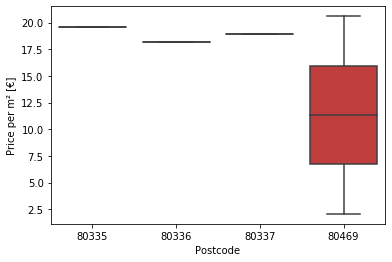

In [139]:
ax = sns.boxplot( x=df_muc_bestchoice["PostalCode"] , y=df_muc_bestchoice["PricePerm2"] )
ax.set(xlabel='Postcode', ylabel='Price per m² [€]')
plt.show()

# 5. Conclusion <a name="conclusion"></a>

The purpose of this project was to identify a borough that is similar to Johns current one and has venues, that are important for John (i.e. arks, coffee, bars, restaurants, grocery stores) in order to narrowing down the search for optimal new borough as a place to live. For this report different analysis have been performed. Considering the average prices per m² for apartments in munich showed, that no matter were John is moving he will most likely find a cheaper apartment.

By just taking into account the venues that are important for John, we could identify three boroughs, which seemed to be most promising as new neighborhood for Johns home. The k-means provided an insight into similar neighborhoods, compared to Johns actual one. After combining these results, we identified one single borough, that is most likely the best choice for Johns new area to live: Ludwigsvorstadt-Isarvorstadt. Further dividing this neighborhood into different postal codes, showed, that the one Ludwigsvorstadt-Isarvorstadt in 80469 would be the best choice, as it is the cheapest area within this neighborhood.

Of course, the price and points of his personal interest are not the only criteria how John should make his final decision, as additional factors like availability of apartments, noise, proximity to friends also matter. However, it serves as an orientation and good neighborhood to start searching.